In [156]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

In [157]:
fx = 800
fy = 800
cx = 0
cy = 0
s = 0

K = np.array([[fx, s, cx],
              [0, fy, cy],  
                [0,   0,   1]])




Calculer l'inverse d'une matrice 

In [ ]:
# Calculer l'inverse d'une matrice 

def invert_matrix(mat):
    """
    Retourne l'inverse de `mat` ou lève une exception si non inversible.
    """
    try:
        return np.linalg.inv(mat)
    except np.linalg.LinAlgError:
        raise ValueError("Matrice singulière : impossible d'appliquer l'inverse.")


In [ ]:
class Repere:

    def __init__(self, origine = np.array([0, 0, 0]), R=np.eye(3)):
        self.rotation = R
        self.i = np.array([1, 0, 0]) @ self.rotation
        self.j = np.array([0, 1, 0]) @ self.rotation
        self.k = np.array([0, 0, 1]) @ self.rotation

        
        

Repérage de la camera

In [160]:
l = 50
M_T_camera_to_word = np.array([[0, 1, 0 ],
                     [0, 0, -1 ],   
                     [-1, 0, 0]])
M_T_word_to_camera = invert_matrix(M_T_camera_to_word)

T = np.eye(4)
T[0:3, 0:3] = M_T_camera_to_word
T[0:3, 3] = np.array([0, l, 0])
T_word_to_camera = invert_matrix(T)
Rot = M_T_word_to_camera


In [161]:
O_w = np.array([0,0,0])
Repere_W = Repere(origine=O_w)


In [ ]:
O_c = np.array([0,l,0])
Repere_C = Repere(O_c, R=Rot )

In [163]:
T_word_to_camera

array([[-0., -0., -1., -0.],
       [ 1.,  0.,  0.,  0.],
       [-0., -1., -0., 50.],
       [ 0.,  0.,  0.,  1.]])

In [164]:
M_w =np.array([15.,  10., -5.,   1.])

M_c =  T_word_to_camera@ M_w
M_c

array([ 5., 15., 40.,  1.])

In [165]:
# T@np.array([10.,  60., 10.,   1.])

In [166]:
# Projection perspective
I_e = K @ M_c[:3]

# Conversion en coordonnées inhomogènes
I_e = np.round(I_e[:2] / I_e[2])
I_e

array([100., 300.])

In [167]:
H = 480*2
W = 640*2
A = np.array([[-1, 0, 0, W/2],
              [0, -1, 0, H/2],
                [0, 0, 1, 0]])  
A

array([[ -1.,   0.,   0., 640.],
       [  0.,  -1.,   0., 480.],
       [  0.,   0.,   1.,   0.]])

In [168]:
I_i = A@np.hstack((I_e, np.array([0., 1.])))
I_i

array([540., 180.,   0.])

In [169]:
Points = [np.array([15., 10., -5. , 1.]),np.array([-60. ,-60., -20. ,  1.]),np.array([-60. ,-60.,-10. ,  1.]) ]
images = []

Fonction resumé

In [170]:
def world_to_image(M_w, K, T_word_to_camera, A):
    """
    Convertit un point du monde vers les coordonnées image.
    
    Args:
        M_w: Point en coordonnées homogènes du monde [x, y, z, 1]
        K: Matrice intrinsèque de la caméra
        T_word_to_camera: Matrice de transformation monde vers caméra
        A: Matrice de transformation image
    
    Returns:
        I_i: Coordonnées du point dans l'image
    """
    # Transformation en coordonnées caméra
    M_c = T_word_to_camera @ M_w
    
    # Projection perspective
    I_e = K @ M_c[:3]
    
    # Conversion en coordonnées inhomogènes
    I_e = np.round(I_e[:2] / I_e[2])
    
    # Transformation en coordonnées image
    I_i = A @ np.hstack((I_e, np.array([0., 1.])))
    
    return I_i

# Test avec M_w
I_i_result = world_to_image(M_w, K, T_word_to_camera, A)
I_i_result

array([540., 180.,   0.])

In [171]:
for i in Points:
    img_point = world_to_image(i, K, T_word_to_camera, A)
    images.append(img_point)

array([540., 180.])

In [204]:
for i in range(len(images)):
    Image[int(images[i][0]),int(images[i][1])] = 0.0

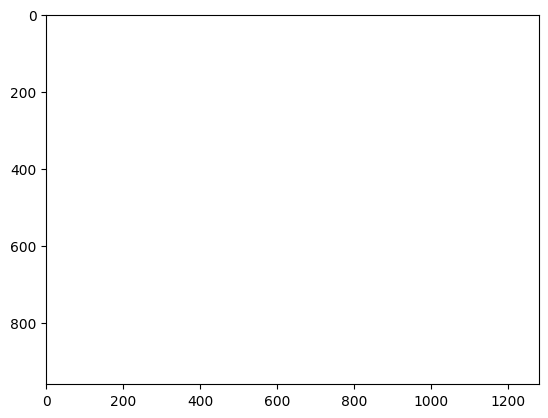

In [205]:
Image =np.ones((H, W)) 

plt.imshow(Image, cmap='gray', origin='upper', vmin=0.0, vmax=1.0)

In [207]:
# Pour chaque point dans images, mettre à 0 ses voisins immédiats dans Image
for point_img in images:
    x, y = int(point_img[0]), int(point_img[1])
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            xi, yi = x + dx, y + dy
            if 0 <= xi < W and 0 <= yi < H:
                Image[yi, xi] = 0.0

In [208]:
print (Image)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [201]:
for point_world, point_img in zip(Points, images):
    x, y = int(point_img[0]), int(point_img[1])
    if 0 <= x < W and 0 <= y < H:
        Image[y, x] = 0

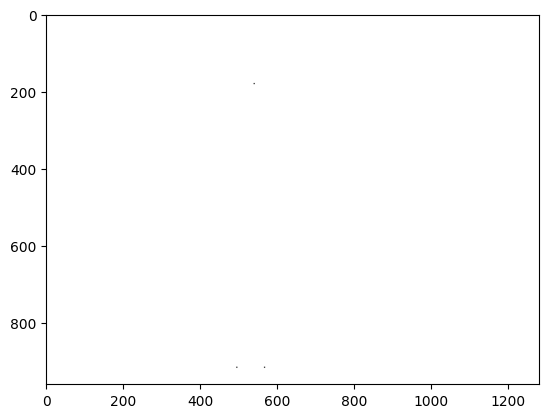

In [209]:
plt.imshow(Image, cmap='gray', origin='upper', vmin=0.0, vmax=1.0)

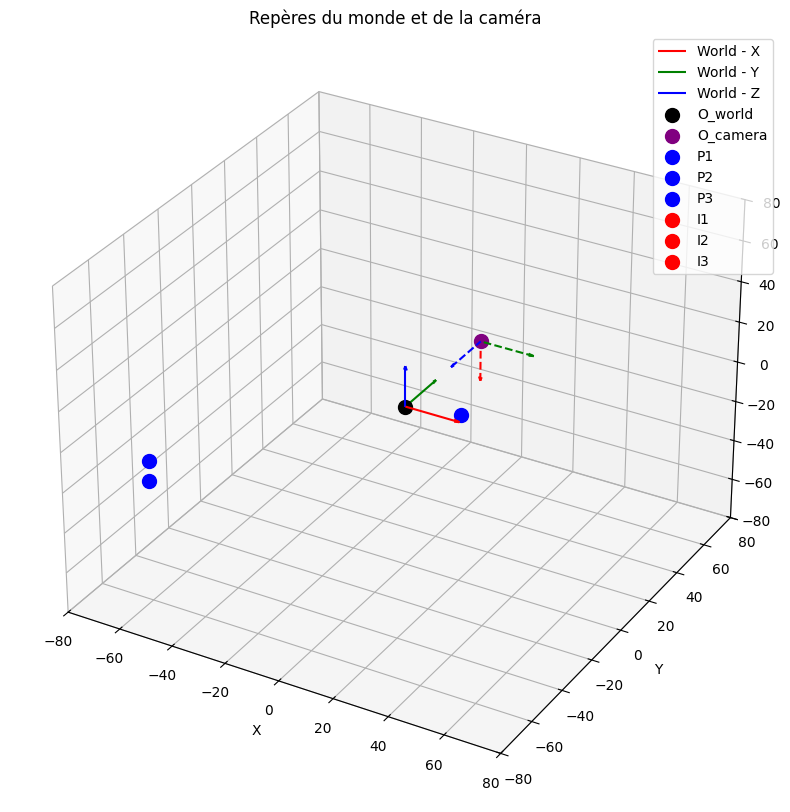

In [178]:
# Afficher les deux repères avec leurs orientations respectives
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fonction pour tracer un repère
def plot_repere(ax, repere, label, scale=20):
    origin = repere.rotation @ np.array([0, 0, 0])
    ax.quiver(0, 0, 0, repere.i[0]*scale, repere.i[1]*scale, repere.i[2]*scale, color='r', arrow_length_ratio=0.1, label=f'{label} - X')
    ax.quiver(0, 0, 0, repere.j[0]*scale, repere.j[1]*scale, repere.j[2]*scale, color='g', arrow_length_ratio=0.1, label=f'{label} - Y')
    ax.quiver(0, 0, 0, repere.k[0]*scale, repere.k[1]*scale, repere.k[2]*scale, color='b', arrow_length_ratio=0.1, label=f'{label} - Z')

# Tracer le repère monde
plot_repere(ax, Repere_W, 'World')

# Tracer le repère caméra (translaté à O_c)
# On crée un repère caméra avec translation
ax.quiver(O_c[0], O_c[1], O_c[2], Repere_C.i[0]*20, Repere_C.i[1]*20, Repere_C.i[2]*20, color='r', arrow_length_ratio=0.1, linestyle='--')
ax.quiver(O_c[0], O_c[1], O_c[2], Repere_C.j[0]*20, Repere_C.j[1]*20, Repere_C.j[2]*20, color='g', arrow_length_ratio=0.1, linestyle='--')
ax.quiver(O_c[0], O_c[1], O_c[2], Repere_C.k[0]*20, Repere_C.k[1]*20, Repere_C.k[2]*20, color='b', arrow_length_ratio=0.1, linestyle='--')

# Points d'origine
ax.scatter(0, 0, 0, color='black', s=100, label='O_world')
ax.scatter(O_c[0], O_c[1], O_c[2], color='purple', s=100, label='O_camera')

ax.scatter(Points[0][0],Points[0][1], Points[0][2], color='blue', s=100, label='P1')
ax.scatter(Points[1][0],Points[1][1], Points[1][2], color='blue', s=100, label='P2')
ax.scatter(Points[2][0],Points[2][1], Points[2][2], color='blue', s=100, label='P3')

ax.scatter(images[0][0],images[0][1], images[0][2], color='red', s=100, label='I1')
ax.scatter(images[1][0],images[1][1], images[1][2], color='red', s=100, label='I2')
ax.scatter(images[2][0],images[2][1], images[2][2], color='red', s=100, label='I3')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-80, 80])
ax.set_ylim([-80, 80])
ax.set_zlim([-80, 80])
ax.legend()
plt.title('Repères du monde et de la caméra')
plt.show()